In [ ]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device, summarize_results

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions
import torch
import torch.nn as nn

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [12]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [13]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [254]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cuda device


  0%|          | 0/100 [00:00<?, ?it/s]

Final training loss: 0.2262406349182129
Final validation loss: 0.5970655679702759
Final validation R^2: 0.20631931519226354


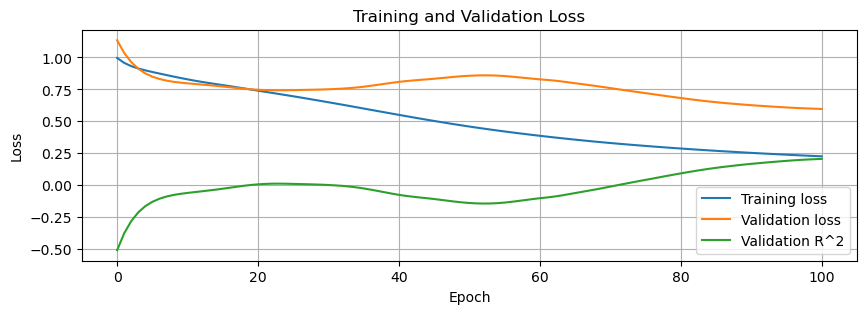

In [255]:
model, training_loss, validation_loss, validation_r_squared = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=5e-4, 
                                                                       weight_decay=1e-1, 
                                                                       verbose=True,
                                                                       seed=SEED)

In [256]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [257]:
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred,
    y_pred_median=None,
    y_pred_best=None,
    y_pred_std=None,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

In [258]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})


In [259]:
# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()


interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

### Smoothing

In [260]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from utils.results import compute_rsquared
from torch.nn import MSELoss

class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        if len(x.shape) == 3:  # Training: input shape (batch_size, 5, 180)
            batch_size, num_samples, num_features = x.size()
            x = x.view(batch_size * num_samples, num_features)
            output = self.linear_relu_stack(x)
            output = output.view(batch_size, num_samples, -1)  # Reshape back to (batch_size, 5, 1)
        elif len(x.shape) == 2:  # Validation: input shape (batch_size, 180)
            output = self.linear_relu_stack(x)
            # output = output.view(x.size(0), 1, -1)  # Reshape to (batch_size, 1, 1) for consistency
        else:
            raise ValueError("Input shape not supported!")
        return output
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations

def get_device(verbose = False):
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    if verbose:
        print(f"Using {device} device")
    return device
    
def custom_train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, custom_loss = MSELoss(), seed = 42, verbose = True):
    set_seed(seed)

    device = get_device(verbose)

    num_features = x_train.shape[-1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = custom_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)

    if verbose:
        print(f"Final training loss: {t_loss.item()}")
        print(f"Final validation loss: {v_loss.item()}")
        print(f"Final validation R^2: {r_squared}")

        plt.figure(figsize=(10, 3))
        plt.plot(training_loss, label="Training loss")
        plt.plot(validation_loss, label="Validation loss")
        plt.plot(valid_r_squared, label="Validation R^2")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.grid()
        plt.legend()
        plt.show()

    
    return model, training_loss, validation_loss, valid_r_squared

In [261]:
preprocessor.dates_high_freq
preprocessor.country_high_freq

df_hf = pd.DataFrame({
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': [x_hf[i] for i in range(len(x_hf))]
})

df_x_train = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'data': [X_train[i] for i in range(len(X_train))]
})

df_hf['date'] = pd.to_datetime(df_hf['date'])
df_x_train['date'] = pd.to_datetime(df_x_train['date'])

In [266]:
batches = []
countries = []
dates = []
for country in df_x_train['country'].unique():
    country_data = df_x_train[df_x_train['country'] == country]
    
    for date_data in country_data.iterrows():
        date = date_data[1]['date']

        prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=1))]
        snd_prev_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date - pd.DateOffset(months=2))]
        next_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date + pd.DateOffset(months=1))]
        snd_next_hf = df_hf[(df_hf['country'] == country) & (df_hf['date'] == date + pd.DateOffset(months=2))]
        
        if len(snd_prev_hf) == 0 or len(prev_hf) == 0 or len(next_hf) == 0 or len(snd_next_hf) == 0:
            print("Skipping", country, date)
            continue

        if len(snd_prev_hf) > 1 or len(prev_hf) > 1 or len(next_hf) > 1 or len(snd_next_hf) > 1:
            print("Warning too big", country, date)
            continue

        batch = []
        
        batch.append(snd_prev_hf['data'].values[0])
        batch.append(prev_hf['data'].values[0])
        batch.append(date_data[1]['data'])
        batch.append(next_hf['data'].values[0])
        batch.append(snd_next_hf['data'].values[0])

        dates.append(date)
        countries.append(country)

        batches.append(batch)

countries = np.array(countries)
dates = np.array(dates)
augmented_data = np.array(batches)

In [267]:
def custom_loss(y_pred, y_true, smoothness_weight=1e-8):
    # Compute usual MSE on actual GDP values
    mse = MSELoss()

    if y_pred.shape[1] > 1:
        prediction_loss = mse(y_pred[:, 2, :], y_true)  # First column is the actual GDP

        # Compute the loss related to smoothness
        smoothness_loss = 0
        for i in range(1, 4):
            smoothness_loss += mse(y_pred[:, i, :], y_pred[:, i - 1, :]) * (1 / (3 * 4))

        return (1 - smoothness_weight) * prediction_loss + smoothness_weight * smoothness_loss
    elif y_pred.shape[1] == 1:
        return mse(y_pred, y_true)
    else:
        raise ValueError("Input shape not supported!")

Using cuda device


  0%|          | 0/100 [00:00<?, ?it/s]

Final training loss: 0.7713192701339722
Final validation loss: 1.4706307649612427
Final validation R^2: -0.9549127621324285


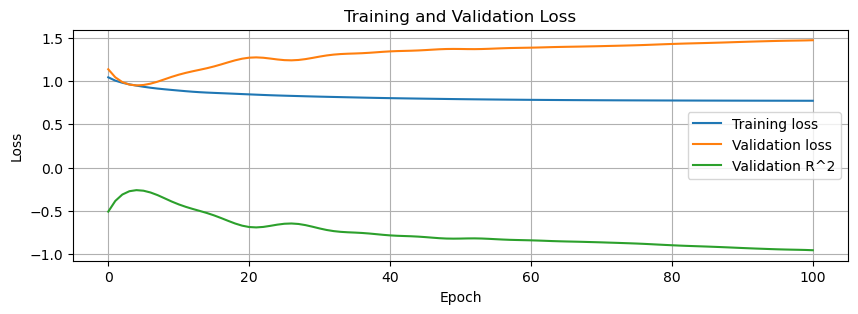

In [268]:
model, training_loss, validation_loss, validation_r_squared = custom_train_nn(augmented_data, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=5e-4, 
                                                                       weight_decay=1e-5, 
                                                                       verbose=True,
                                                                       custom_loss= custom_loss,
                                                                       seed=SEED)

In [ ]:
device = get_device(False)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()


In [249]:

# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'y_pred': y_pred,
    'y_true': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'y_pred': y_pred_train,
    'y_true': y_train,
    'Set': 'Training'
})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["y_pred", "y_true"], 
    var_name="Type", value_name="Value"
)

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
    )
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

ValueError: All arrays must be of the same length